### Import những thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import gensim
from gensim.models import Word2Vec

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from newspaper import Article

### Đọc và khám phá dữ liệu

In [2]:
# Đọc file dữ liệu
df = pd.read_csv("/Users/ttcenter/Downloads/news.csv")

# Xem kích thước và vài dòng đầu của dữ liệu
print("Shape:", df.shape)
df.head()

Shape: (20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# Xem thông tin của tập hợp các tin giả và tin thật
fake = df[df["label"] == 1].count()
real = df[df["label"] == 0].count()
df_counts = {
    "": ["FAKE", "REAL"],
    "Total news": [fake["id"], real["id"]],
    "Total titles": [fake["title"], real["title"]],
    "Total authors": [fake["author"], real["author"]],
    "Total texts": [fake["text"], real["text"]],
}
pd.DataFrame(df_counts)

,,Total news,Total titles,Total authors,Total texts
0,FAKE,10413,9855,8482,10374
1,REAL,10387,10387,10361,10387


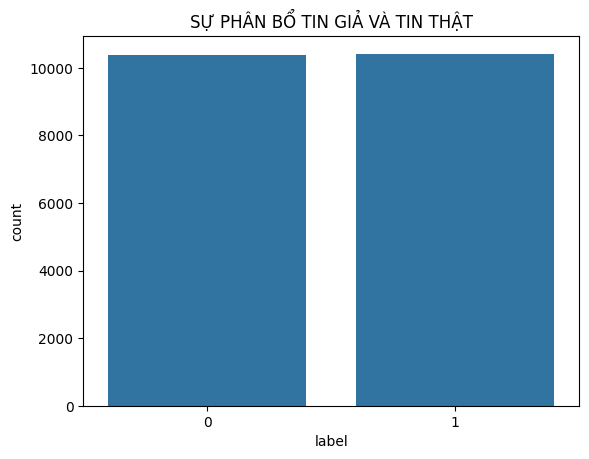

In [4]:
# Xem dữ liệu có bị mất cân bằng hay không
# Trực quan hoá sự phân bổ các lớp bằng biểu đồ cột
sns.countplot(df, x='label')
plt.title('SỰ PHÂN BỔ TIN GIẢ VÀ TIN THẬT')
plt.show()

In [5]:
# Liệt kê các giá trị thiếu
missing_values_total = df.isnull().sum().sum()
missing_values = df.isnull().sum()
# Hiển thị các cột có giá trị thiếu
missing_values = missing_values[missing_values > 0]

print ("Tổng giá trị thiếu:", missing_values_total)
print ("Các cột có giá trị thiếu:")
print (missing_values)

Tổng giá trị thiếu: 2554
Các cột có giá trị thiếu:
title      558
author    1957
text        39
dtype: int64


## Tiền xử lý dữ liệu

In [6]:
# Thay đổi các nhãn của dataframe
df["label"] = df["label"].astype("object")
df.loc[(df["label"] == 1), ["label"]] = "FAKE"
df.loc[(df["label"] == 0), ["label"]] = "REAL"

# Xem lại dữ liệu
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,FAKE
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,REAL
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",FAKE
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,FAKE
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,FAKE


### Xử lý Missing Values

In [7]:
# Xoá các hàng có ít nhất một giá trị null (NaN)
df = df.dropna(how='any')

# Kiểm tra lại số lượng các giá trị null
print(df.isnull().sum())

id        0
title     0
author    0
text      0
label     0
dtype: int64


In [8]:
# Tạo cột mới hợp nhất giá trị của cột 'title','author' và 'text'
df['combined_info'] = df['author'] + ' ' + df['title'] + ' ' + df['text']
# Xem cột mới
df["combined_info"].head()

0    Darrell Lucus House Dem Aide: We Didn’t Even S...
1    Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2    Consortiumnews.com Why the Truth Might Get You...
3    Jessica Purkiss 15 Civilians Killed In Single ...
4    Howard Portnoy Iranian woman jailed for fictio...
Name: combined_info, dtype: object

### Làm sạch và chuẩn hoá dữ liệu

In [9]:
# Chuyển thành chữ thường, loại bỏ các dấu câu
df['combined_info'] = df['combined_info'].str.lower().replace(f'[{string.punctuation}]', '', regex=True) 
df['combined_info'].head()

0    darrell lucus house dem aide we didn’t even se...
1    daniel j flynn flynn hillary clinton big woman...
2    consortiumnewscom why the truth might get you ...
3    jessica purkiss 15 civilians killed in single ...
4    howard portnoy iranian woman jailed for fictio...
Name: combined_info, dtype: object

## Trực quan hoá dữ liệu: Word Cloud

### Vẽ Word Cloud cho những bài báo có nhãn 'Fake'

### Vẽ Word Cloud cho những bài báo có nhãn 'Real'

### Chia dữ liệu thành tập huấn luyện và tập kiểm tra

In [10]:
# Chia bộ dữ liệu thành train_set và test_set
X_train, X_test, y_train, y_test = train_test_split(df["combined_info"], df['label'], test_size=0.2, random_state=42)

## Xử lý ngôn ngữ tự nhiên NLP

### TF-IDF (Term Frequency-Inverse Document Frequency)

In [11]:
# Khởi tạo TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# Huấn luyện và biến đổi tập huấn luyện, biến đổi tập kiểm tra
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Xem 2 dòng đầu tiên của X_train_tfidf
print("X_train_tfidf:", X_train_tfidf[:2])
# Xem 2 dòng đầu tiên của X_test_tfidf
print("X_test_tfidf:", X_test_tfidf[:2])

X_train_tfidf:   (0, 70725)	0.048473438500665815
  (0, 89031)	0.05212375611706561
  (0, 142975)	0.07218080490375312
  (0, 113473)	0.02556359102137659
  (0, 95623)	0.4057937255243339
  (0, 83048)	0.12970028940351505
  (0, 96310)	0.27483145085476207
  (0, 36108)	0.0653894342232622
  (0, 48905)	0.02761462742309561
  (0, 92114)	0.03884053725781897
  (0, 148301)	0.019441003759299236
  (0, 134189)	0.009221544812401148
  (0, 126356)	0.023976863555484
  (0, 83065)	0.22264489865235296
  (0, 48907)	0.04389471915310061
  (0, 81936)	0.0444285351784578
  (0, 106285)	0.19584574972003113
  (0, 8132)	0.02125162970558436
  (0, 97462)	0.1276162685153673
  (0, 53067)	0.12224691727107825
  (0, 62355)	0.02005108131282196
  (0, 11433)	0.029675225870333784
  (0, 84770)	0.14003853051702075
  (0, 40814)	0.22763168302995931
  (0, 108302)	0.05996120776497048
  :	:
  (1, 48439)	0.037023132014209155
  (1, 24513)	0.02484529044539655
  (1, 17939)	0.022115582205931298
  (1, 122425)	0.02767122825421399
  (1, 140576)	0

### Word2Vec

In [12]:
# Loại bỏ stop words 
stop_words = ENGLISH_STOP_WORDS
X_train_tokens = [
    [word for word in tweet.split() if word not in stop_words] 
    for tweet in X_train]

X_test_tokens = [
    [word for word in tweet.split() if word not in stop_words] 
    for tweet in X_test]

In [13]:
# Đào tạo mô hình Word2Vec trên X_train
model = Word2Vec(sentences=X_train_tokens, vector_size=50, window=5, min_count=1, workers=4)

# Vector hóa X_train và X_test sử dụng Word2Vec
X_train_w2v = np.array([
    np.mean([model.wv[word] for word in tweet if word in model.wv], axis=0) 
    for tweet in X_train_tokens])
X_test_w2v = np.array([
    np.mean([model.wv[word] for word in tweet if word in model.wv], axis=0) 
    for tweet in X_test_tokens])
# Xem kết quả
print("X_train_w2v:", X_train_w2v[:1])
print("X_test_w2v:", X_test_w2v[:1])

X_train_w2v: [[ 2.9926020e-01 -3.4798634e-01  3.9890540e-01  4.3877757e-01
  -1.3963088e+00 -2.9165715e-01  1.8034835e-01  8.9162171e-01
  -2.0952344e-01 -1.0556883e+00  8.4333522e-03  9.9858418e-02
   6.4412916e-01 -1.2457769e+00  7.9523817e-02  3.7712000e-02
   5.1175421e-01 -8.5750699e-01 -4.4968796e-01 -8.2982302e-01
  -9.3210405e-01  1.8569636e-01  1.8173190e+00 -4.5315349e-01
   2.1169227e-01  2.1528304e-01 -1.0401329e+00  8.2574779e-01
  -1.1695114e-01  8.7211514e-01  1.2455594e-03 -6.4168221e-01
   2.7353063e-01  3.8956773e-02 -7.2733521e-01 -7.6383352e-02
  -8.0809817e-02 -4.9443001e-01 -3.1285512e-01  4.0048307e-01
   3.6760867e-01 -5.0348663e-01 -2.6316798e-01  5.3047270e-01
   8.7764215e-01 -4.8503256e-01 -5.8814138e-01 -1.5878437e+00
   5.9336245e-01  8.7989628e-01]]
X_test_w2v: [[ 0.29803973  0.12185412  1.1149397  -0.37928566  0.01350681 -0.1916352
   0.40589952  1.9594927  -0.26300785 -0.52320385 -0.24667461 -0.25693387
  -0.0213815  -1.0249517  -0.5872251  -0.58834416 

## Khởi tạo các mô hình và thực hiện dự đoán

### Passive Aggression Classifier (PAC)

In [14]:
# Khởi tạo PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=100)
param_grid1 = {
    'C': [0.1, 1, 10],  # Regularization strength
    'max_iter': [50, 100],  # Number of iterations
    'tol': [1e-4, 1e-3]  # Tolerance to stop
}
grid_search1 = GridSearchCV(pac, param_grid1, cv=5, scoring='accuracy', n_jobs=-1)

### PAC với phương pháp xử lý TF-IDF

In [15]:
grid_search1.fit(X_train_tfidf, y_train)

# In ra các tham số tối ưu và điểm số tốt nhất
print("Best parameters found by GridSearchCV:", grid_search1.best_params_)
print("Best cross-validation score by GridSearchCV: {:.2f}%".format(grid_search1.best_score_ * 100))


Best parameters found by GridSearchCV: {'C': 0.1, 'max_iter': 100, 'tol': 0.001}
Best cross-validation score by GridSearchCV: 97.66%


In [16]:
# Lấy mô hình tốt nhất từ GridSearchCV
pac1 = grid_search1.best_estimator_

# Đánh giá mô hình trên tập kiểm tra
y_pred1 = pac1.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred1))



Classification Report:
              precision    recall  f1-score   support

        FAKE       0.98      0.97      0.97      1575
        REAL       0.98      0.98      0.98      2082

    accuracy                           0.98      3657
   macro avg       0.98      0.97      0.98      3657
weighted avg       0.98      0.98      0.98      3657



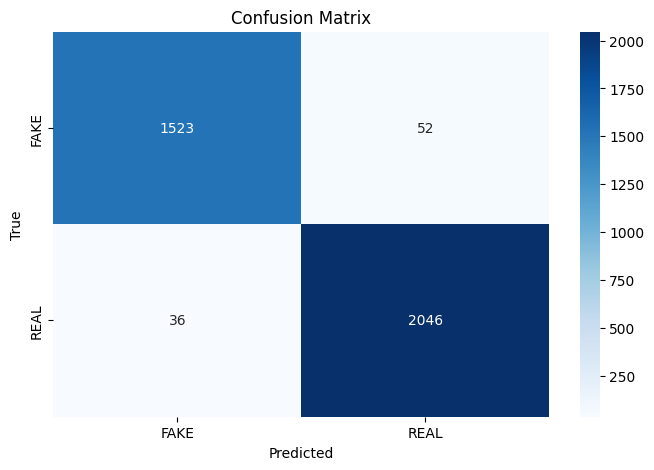

In [17]:
# In ra confusion matrix
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Cross-validation để kiểm tra tính ổn định của mô hình
cv_scores1 = cross_val_score(pac1, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("\nCross-validation scores:", cv_scores1)
print("Average cross-validation score: {:.2f}%".format(cv_scores1.mean() * 100))


Cross-validation scores: [0.97505126 0.97812714 0.97402597 0.98119658 0.97367521]
Average cross-validation score: 97.64%


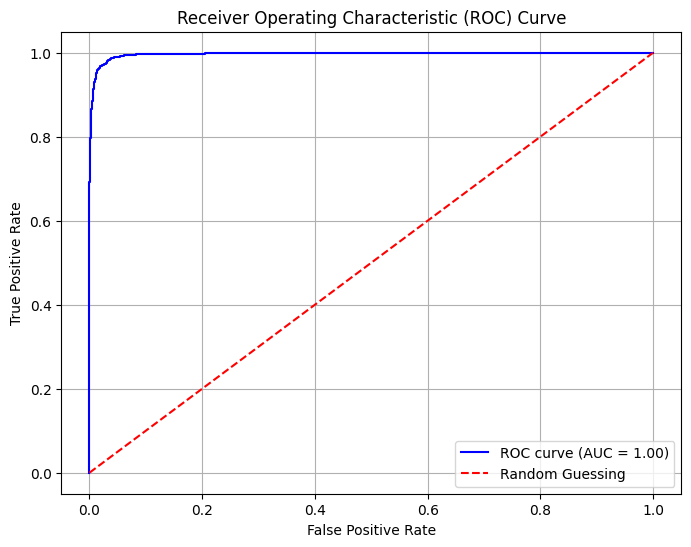

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Khởi tạo và gán nhãn 0 cho 'REAL' và 1 cho 'FAKE'
label_encoder = LabelEncoder()
label_encoder.fit(['REAL', 'FAKE'])  # Đảm bảo 'REAL' thành 0 và 'FAKE' thành 1
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# Tính toán decision scores cho ROC AUC
y_scores1 = pac1.decision_function(X_test_tfidf)  # sử dụng decision_function cho PAC

# Tính toán các giá trị fpr, tpr và thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores1)
auc_score1 = roc_auc_score(y_test, y_scores1)

# Vẽ đồ thị ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score1:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### PAC với phương pháp xử lý Word2vec

In [19]:
# Huấn luyện mô hình trên tập dữ liệu đã chuyển đổi bằng Word2vec
grid_search1.fit(X_train_w2v, y_train)

# In ra các tham số tối ưu và điểm số tốt nhất
print("Best parameters found by GridSearchCV:", grid_search1.best_params_)
print("Best cross-validation score by GridSearchCV: {:.2f}%".format(grid_search1.best_score_ * 100))

Best parameters found by GridSearchCV: {'C': 1, 'max_iter': 50, 'tol': 0.001}
Best cross-validation score by GridSearchCV: 91.30%


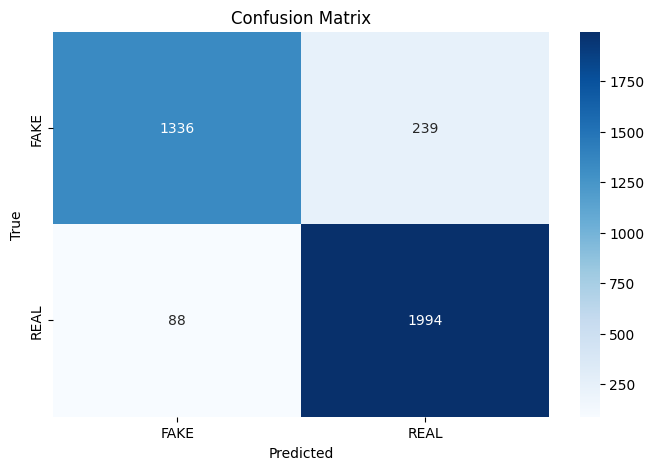

In [20]:
# Lấy mô hình tốt nhất từ GridSearchCV
pac2 = grid_search1.best_estimator_

# Đánh giá mô hình trên tập kiểm tra
y_pred2 = pac2.predict(X_test_w2v)

# In ra confusion matrix
cm = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Tính và in ra classificasion report
print("\nClassification Report:")
print(classification_report(y_test, y_pred2))


Classification Report:
              precision    recall  f1-score   support

        FAKE       0.94      0.85      0.89      1575
        REAL       0.89      0.96      0.92      2082

    accuracy                           0.91      3657
   macro avg       0.92      0.90      0.91      3657
weighted avg       0.91      0.91      0.91      3657



In [22]:
# Cross-validation để kiểm tra tính ổn định của mô hình
cv_scores2 = cross_val_score(pac2, X_train_w2v, y_train, cv=5, scoring='accuracy')
print("\nCross-validation scores:", cv_scores2)
print("Average cross-validation score: {:.2f}%".format(cv_scores2.mean() * 100))


Cross-validation scores: [0.90704033 0.9203691  0.88585099 0.69401709 0.93196581]
Average cross-validation score: 86.78%


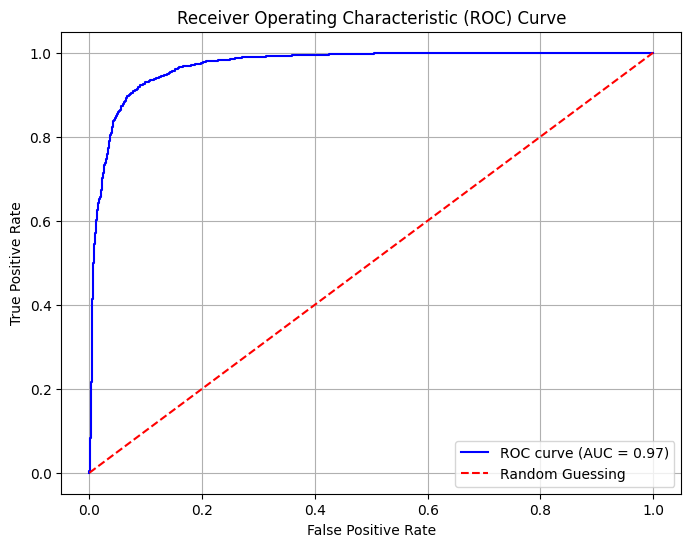

In [50]:
# Tính toán decision scores cho ROC AUC
y_scores2 = pac2.decision_function(X_test_w2v)  # sử dụng decision_function cho PAC

# Tính toán các giá trị fpr, tpr và thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores2)
auc_score2 = roc_auc_score(y_test, y_scores2)

# Vẽ đồ thị ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score2:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Logistic Regression

In [32]:
# Khởi tạo mô hình Logistic Regression
logistic_model = LogisticRegression(max_iter=500)
param_grid2={
        'C': [0.1, 0.01],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l2']}
grid_search2 = GridSearchCV(logistic_model, param_grid2, cv=5, scoring='accuracy', n_jobs=-1)

### Logistic Regression với phương pháp xử lý TF-IDF

In [33]:
# Huấn luyện mô hình trên tập dữ liệu đã chuyển đổi bằng TF-IDF
grid_search2.fit(X_train_tfidf, y_train)

# In ra các tham số tối ưu và điểm số tốt nhất
print("Best parameters found by GridSearchCV:", grid_search2.best_params_)
print("Best cross-validation score by GridSearchCV: {:.2f}%".format(grid_search2.best_score_ * 100))

Best parameters found by GridSearchCV: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score by GridSearchCV: 93.50%


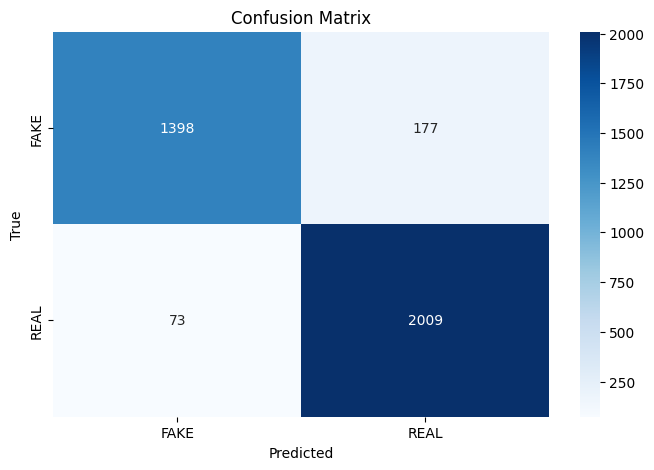

In [34]:
# Lấy mô hình tốt nhất từ GridSearchCV
logistic1 = grid_search2.best_estimator_

# Đánh giá mô hình trên tập kiểm tra
y_pred3 = logistic1.predict(X_test_tfidf)

# In ra confusion matrix
cm = confusion_matrix(y_test, y_pred3)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Tính và in classification report 
print('\nClassification Report (Logistic with TF-IDF):') 
print(classification_report(y_test, y_pred3))


Classification Report (Logistic with TF-IDF):
              precision    recall  f1-score   support

        FAKE       0.95      0.89      0.92      1575
        REAL       0.92      0.96      0.94      2082

    accuracy                           0.93      3657
   macro avg       0.93      0.93      0.93      3657
weighted avg       0.93      0.93      0.93      3657



In [36]:
# Cross-validation để kiểm tra tính ổn định của mô hình
cv_scores3 = cross_val_score(logistic1, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("\nCross-validation scores:", cv_scores3)
print("Average cross-validation score: {:.2f}%".format(cv_scores3.mean() * 100))


Cross-validation scores: [0.9391661  0.93062201 0.92857143 0.93948718 0.93641026]
Average cross-validation score: 93.49%


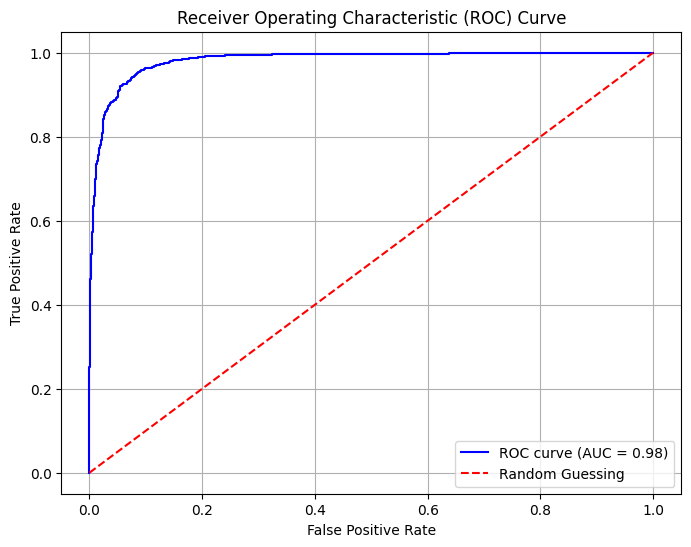

In [52]:
# Tính toán decision scores cho ROC AUC
y_scores3 = logistic1.predict_proba(X_test_tfidf)[:, 1]  # sử dụng decision_function cho PAC

# Tính toán các giá trị fpr, tpr và thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores3)
auc_score3 = roc_auc_score(y_test, y_scores3)

# Vẽ đồ thị ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score3:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Logistic Regression với phương pháp xử lý Word2vec

In [37]:
# Huấn luyện mô hình trên tập dữ liệu đã chuyển đổi bằng Word2vec
grid_search2.fit(X_train_w2v, y_train)

# In ra các tham số tối ưu và điểm số tốt nhất
print("Best parameters found by GridSearchCV:", grid_search2.best_params_)
print("Best cross-validation score by GridSearchCV: {:.2f}%".format(grid_search2.best_score_ * 100))

Best parameters found by GridSearchCV: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score by GridSearchCV: 92.60%


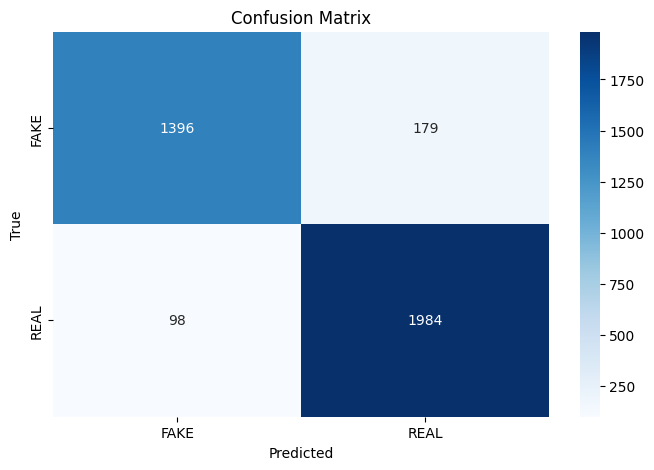

In [39]:
# Lấy mô hình tốt nhất từ GridSearchCV
logistic2 = grid_search2.best_estimator_

# Đánh giá mô hình trên tập kiểm tra
y_pred4 = logistic2.predict(X_test_w2v)

# In ra confusion matrix
cm = confusion_matrix(y_test, y_pred4)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [40]:
# Tính và in classification report 
print('\nClassification Report (LogisticRegression with Word2vec):') 
print(classification_report(y_test, y_pred4))


Classification Report (LogisticRegression with Word2vec):
              precision    recall  f1-score   support

        FAKE       0.93      0.89      0.91      1575
        REAL       0.92      0.95      0.93      2082

    accuracy                           0.92      3657
   macro avg       0.93      0.92      0.92      3657
weighted avg       0.92      0.92      0.92      3657



In [41]:
# Cross-validation để kiểm tra tính ổn định của mô hình
cv_scores4 = cross_val_score(logistic2, X_train_w2v, y_train, cv=5, scoring='accuracy')
print("\nCross-validation scores:", cv_scores4)
print("Average cross-validation score: {:.2f}%".format(cv_scores4.mean() * 100))


Cross-validation scores: [0.93062201 0.92378674 0.92173616 0.9234188  0.93059829]
Average cross-validation score: 92.60%


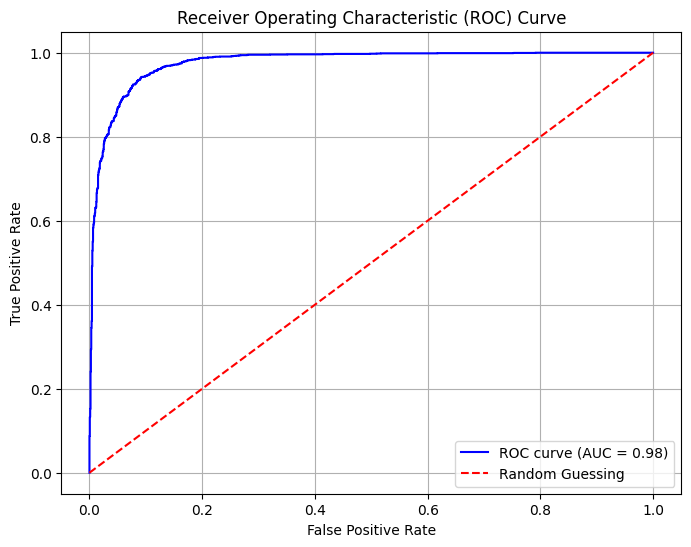

In [53]:
# Tính toán decision scores cho ROC AUC
y_scores4 = logistic2.predict_proba(X_test_w2v)[:, 1]  # sử dụng decision_function cho PAC

# Tính toán các giá trị fpr, tpr và thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores4)
auc_score4 = roc_auc_score(y_test, y_scores4)

# Vẽ đồ thị ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score4:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## So sánh hai mô hình học máy

In [67]:
# Nếu muốn chuyển ngược lại từ 0, 1 thành 'REAL' và 'FAKE'
y_train = label_encoder.inverse_transform(y_train)
y_test = label_encoder.inverse_transform(y_test)
  

In [68]:
print(set(y_train))  # Kiểm tra nhãn trong y_train
print(set(y_test))   # Kiểm tra nhãn trong y_test


{'FAKE', 'REAL'}
{'FAKE', 'REAL'}


In [114]:

# Tính toán các chỉ số cho PAC (TF-IDF) (FAKE là positive class)
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred2, pos_label='FAKE')
recall1 = recall_score(y_test, y_pred1, pos_label='FAKE')
f1_score1 = f1_score(y_test, y_pred1, pos_label='FAKE')

# Tính toán các chỉ số cho Logistic Regression (TF-IDF) (FAKE là positive class)
accuracy3 = accuracy_score(y_test, y_pred3)
precision3 = precision_score(y_test, y_pred3, pos_label='FAKE')
recall3 = recall_score(y_test, y_pred3, pos_label='FAKE')
f1_score3 = f1_score(y_test, y_pred3, pos_label='FAKE')
# Tính toán các chỉ số cho PAC (Word2vec) (FAKE là positive class)
accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2, pos_label='FAKE')
recall2 = recall_score(y_test, y_pred2, pos_label='FAKE')
f1_score2 = f1_score(y_test, y_pred2, pos_label='FAKE')

# Tính toán các chỉ số cho Logistic Regression (Word2vec) (FAKE là positive class)
accuracy4 = float(0.92)
precision4 = float(0.93)
recall4 = float (0.89)
f1_score4= float (0.91)

# Tạo dữ liệu cho biểu đồ
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score','CV_score', 'AUC Score']
model1_scores = [accuracy1, precision1, recall1, f1_score1, cv_scores1.mean(), auc_score1]
model2_scores = [accuracy2, precision2, recall2, f1_score2, cv_scores2.mean(), auc_score2]
model3_scores = [accuracy3, precision3, recall3, f1_score3, cv_scores3.mean(), auc_score3]
model4_scores = [accuracy4, precision4, recall4, f1_score4, cv_scores4.mean(), auc_score4]

In [105]:
# Kiểm tra xem các danh sách có phần tử đồng nhất không
print(model1_scores)
print(model2_scores)

[0.9759365600218759, 0.9382022471910112, 0.966984126984127, 0.9719208679004467, 0.976415233888918, 0.9969293871887531]
[0.9105824446267432, 0.9382022471910112, 0.8482539682539683, 0.8909636545515172, 0.8678486659539291, 0.9706570300230242]


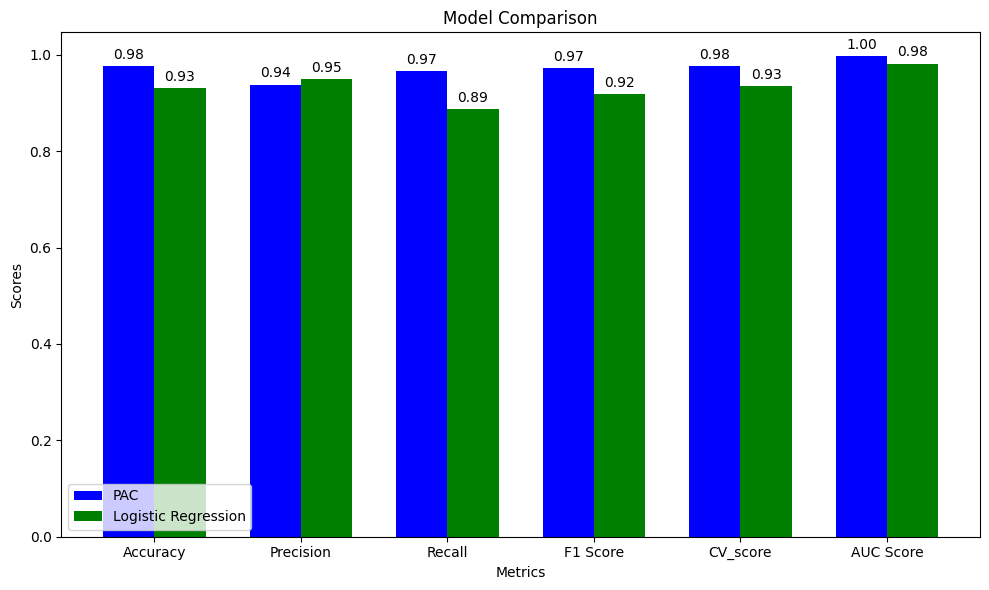

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Tạo DataFrame để so sánh các chỉ số giữa hai mô hình
data = {
    'Metrics': metrics,
    'Model 1': model1_scores,
    'Model 3': model3_scores
}

df_scores = pd.DataFrame(data)

# Vẽ biểu đồ so sánh
x = np.arange(len(metrics))  # Vị trí các cột

fig, ax = plt.subplots(figsize=(10, 6))

# Tạo bar chart cho mỗi mô hình
bar_width = 0.35  # Độ rộng cột
rects1 = ax.bar(x - bar_width / 2, df_scores['Model 1'], bar_width, label='PAC', color='blue')
rects3 = ax.bar(x + bar_width / 2, df_scores['Model 3'], bar_width, label='Logistic Regression', color='green')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Hiển thị giá trị trên cột
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Đặt nhãn ở trên cột
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects3)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


### So sánh PAC và Logistic Regression khi sử dụng phương pháp xử lý Word2Vec

In [115]:
print(model2_scores)
print(model4_scores)

[0.9105824446267432, 0.9382022471910112, 0.8482539682539683, 0.8909636545515172, 0.8678486659539291, 0.9706570300230242]
[0.92, 0.93, 0.89, 0.91, 0.9260324003481898, 0.976310171843313]


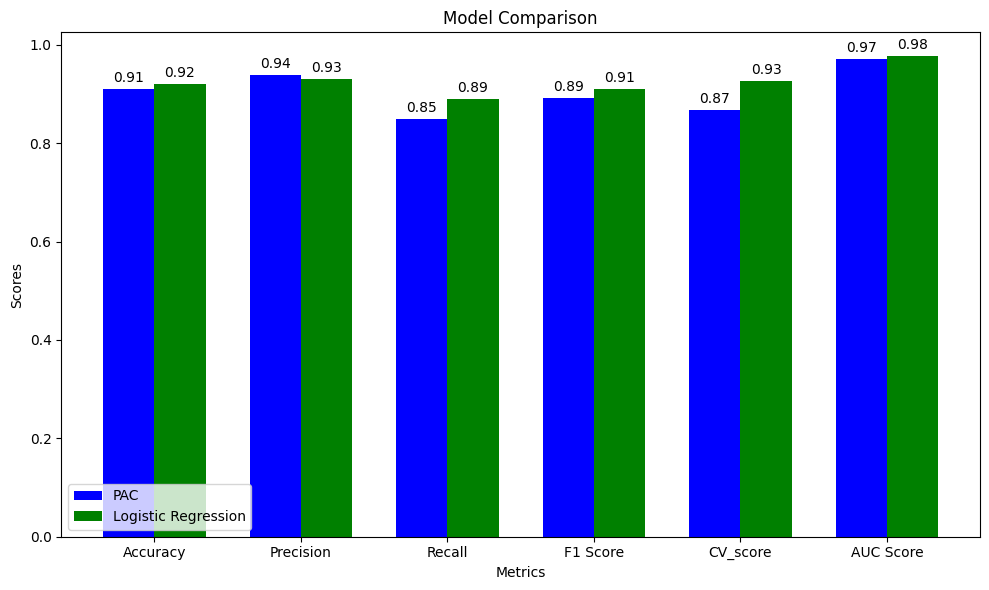

In [116]:

# Tạo DataFrame để so sánh các chỉ số giữa hai mô hình
data = {
    'Metrics': metrics,
    'Model 2': model2_scores,
    'Model 4': model4_scores
}

df_scores = pd.DataFrame(data)

# Vẽ biểu đồ so sánh
x = np.arange(len(metrics))  # Vị trí các cột

fig, ax = plt.subplots(figsize=(10, 6))

# Tạo bar chart cho mỗi mô hình
bar_width = 0.35  # Độ rộng cột
rects2 = ax.bar(x - bar_width / 2, df_scores['Model 2'], bar_width, label='PAC', color='blue')
rects4 = ax.bar(x + bar_width / 2, df_scores['Model 4'], bar_width, label='Logistic Regression', color='green')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Hiển thị giá trị trên cột
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Đặt nhãn ở trên cột
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects2)
add_labels(rects4)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()



## So sánh 2 phương pháp xử lý ngôn ngữ tự nhiên NLP

## So sánh TF- IDF và Word2Vec trên mô hình PAC

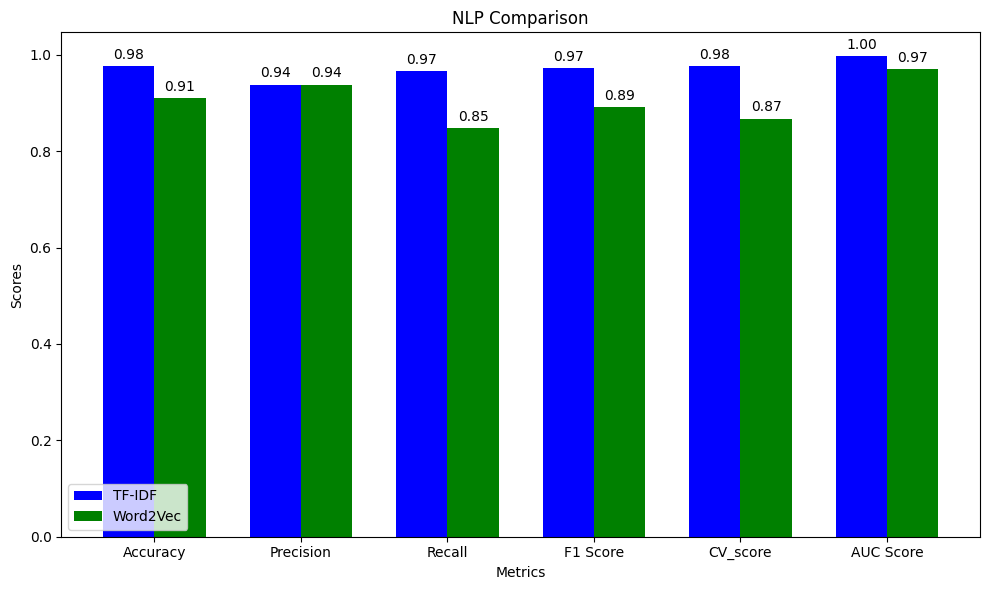

In [117]:
# Tạo DataFrame để so sánh các chỉ số giữa hai mô hình
data = {
    'Metrics': metrics,
    'Model 1': model1_scores,
    'Model 2': model2_scores
}

df_scores = pd.DataFrame(data)

# Vẽ biểu đồ so sánh
x = np.arange(len(metrics))  # Vị trí các cột

fig, ax = plt.subplots(figsize=(10, 6))

# Tạo bar chart cho mỗi mô hình
bar_width = 0.35  # Độ rộng cột
rects1 = ax.bar(x - bar_width / 2, df_scores['Model 1'], bar_width, label='TF-IDF', color='blue')
rects2 = ax.bar(x + bar_width / 2, df_scores['Model 2'], bar_width, label='Word2Vec', color='green')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('NLP Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Hiển thị giá trị trên cột
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Đặt nhãn ở trên cột
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()



### So sánh TF-IDF và Word2Vec trên mô hình Logistic Regression

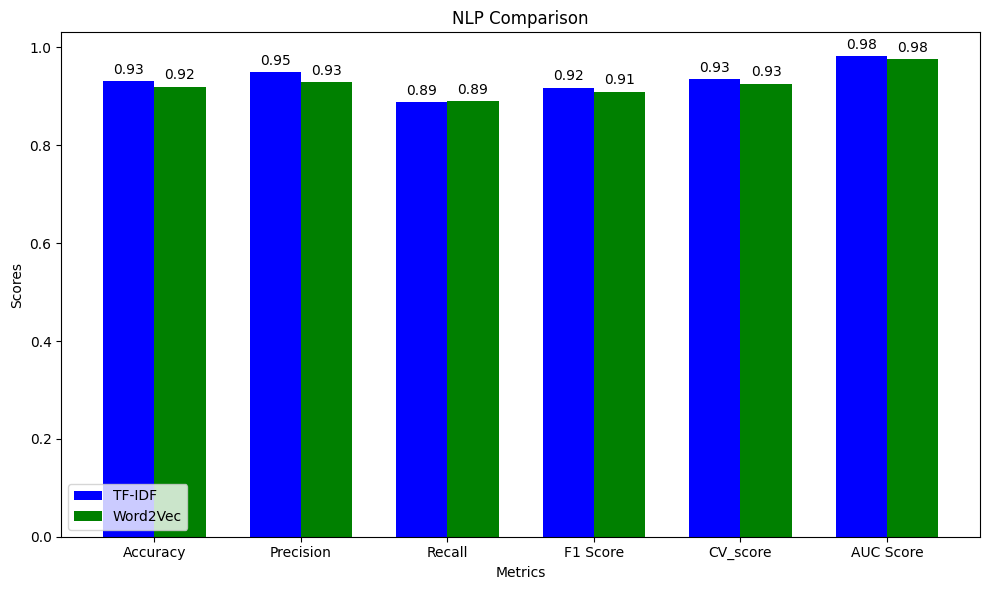

In [118]:
# Tạo DataFrame để so sánh các chỉ số giữa hai mô hình
data = {
    'Metrics': metrics,
    'Model 3': model3_scores,
    'Model 4': model4_scores
}

df_scores = pd.DataFrame(data)

# Vẽ biểu đồ so sánh
x = np.arange(len(metrics))  # Vị trí các cột

fig, ax = plt.subplots(figsize=(10, 6))

# Tạo bar chart cho mỗi mô hình
bar_width = 0.35  # Độ rộng cột
rects3 = ax.bar(x - bar_width / 2, df_scores['Model 3'], bar_width, label='TF-IDF', color='blue')
rects4 = ax.bar(x + bar_width / 2, df_scores['Model 4'], bar_width, label='Word2Vec', color='green')

# Thêm nhãn và tiêu đề
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('NLP Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Hiển thị giá trị trên cột
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Đặt nhãn ở trên cột
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects3)
add_labels(rects4)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


## KIỂM THỬ

### Nhập URL bài báo và dự đoán 

In [16]:
url = input("Nhập url của bài báo")
article = Article(url)
article.download()
article.parse()

text_input = f"Title: {article.title}\nAuthor: {', '.join(article.authors)}\nText:\n{article.text}"
text_input = text_input.lower()  # Chuyển thành chữ thường
text_input = re.sub(f"[{re.escape(string.punctuation)}]", '', text_input)  # Loại bỏ dấu câu
text_tfidf = tfidf_vectorizer.transform([text_input])  
label_pred = pac.predict(text_tfidf)
print(f"Kết quả dự đoán: {label_pred}")
print(" ".join(text_input.split(" ")[:100]) + " ...")

Nhập url của bài báo https://www.nytimes.com/interactive/2024/10/22/us/politics/project-2025-trump-heritage-foundation.html


Kết quả dự đoán: ['REAL']
title the many links between project 2025 and trump’s world
author elena shao ashley wu authors
text
the many links between project 2025 and trump’s world

former president donald j trump has repeatedly claimed that he had nothing to do with project 2025 the heritage foundation’s conservative policy initiative to reshape the federal government mr trump has said that he has not read its proposals and does not know who is behind it but project 2025 has numerous ties to mr trump and his campaign a new york times analysis has found

the people behind project 2025 are no strangers to the former president the ...


### Tự nhập dữ liệu về bài báo rồi dự đoán

In [17]:
title = input("Nhập tiêu đề")
author = input("Nhập tác giả")
text = input("Nhập nội dung")

text_input = f"Title: {title}\nAuthor: {author}\nText:\n{text}"
text_input = text_input.lower()  # Chuyển thành chữ thường
text_input = re.sub(f"[{re.escape(string.punctuation)}]", '', text_input)  # Loại bỏ dấu câu
text_tfidf = tfidf_vectorizer.transform([text_input])
label_pred = pac.predict(text_tfidf)

print(f"Kết quả dự đoán: {label_pred}")
print(" ".join(text_input.split(" ")[:100]) + " ...")

Nhập tiêu đề Donald Trump Launches Revolutionary New Initiative: "TrumpTowns" to Reshape America
Nhập tác giả Jane Smith
Nhập nội dung In a surprise announcement today, former President Donald Trump unveiled an ambitious plan aimed at reshaping America: the creation of "TrumpTowns." During a live press conference in Florida, Trump described these self-sufficient communities as a revolutionary step toward economic independence and national unity.  "Today, we are taking America back!" Trump exclaimed, flanked by a group of supporters wearing red "Make America Great Again" caps. "TrumpTowns will be places where hardworking Americans can live, work, and thrive without government interference."  According to Trump, each TrumpTown will be designed to foster a sense of community, featuring homes, schools, and businesses all built around a central theme of patriotism and self-reliance. The towns will be equipped with everything residents need, from grocery stores to recreational facilities, al

Kết quả dự đoán: ['FAKE']
title donald trump launches revolutionary new initiative trumptowns to reshape america
author jane smith
text
in a surprise announcement today former president donald trump unveiled an ambitious plan aimed at reshaping america the creation of trumptowns during a live press conference in florida trump described these selfsufficient communities as a revolutionary step toward economic independence and national unity  today we are taking america back trump exclaimed flanked by a group of supporters wearing red make america great again caps trumptowns will be places where hardworking americans can live work and thrive without government interference  according to trump each trumptown will be ...


### So sánh TF-IDF và Word2Vec trên mô hình PAC